<a href="https://colab.research.google.com/github/bhavya6701/comp473-project/blob/main/comp473_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Artistic Style Transfer Using Convolutional Neural Networks
**Authors:** Shibin Koshy [40295019], Ruturajsinh Vihol [40154693], Bhavya Manjibhai Ruparelia [40164863]

## Imports

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.optim as optim
from torchvision import transforms, models
from tqdm import tqdm
import warnings

In [2]:
# Filter out warnings
warnings.filterwarnings('ignore')

# Set the home directory
HOME = os.getcwd()

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Models

**VGG-16**: A convolutional neural network with 16 layers, popular for style transfer due to its ability to capture detailed hierarchical features across layers. Pre-trained on ImageNet, it offers a balance between depth and computational efficiency.

**VGG-19**: An extended version of VGG-16 with 19 layers, providing deeper feature representations. This model can capture more complex details, enhancing style extraction for artistic image synthesis.

**ResNet-50**: A 50-layer residual network with skip connections, which helps retain both high- and low-level features. This architecture is well-suited for extracting intricate textures and patterns in style transfer tasks.

**DenseNet-121**: A densely connected network with 121 layers, where each layer connects to every other layer, enhancing feature reuse and continuity. DenseNet-121 is efficient and effective at capturing fine-grained details in style patterns.

**Vision Transformer (ViT)**: A transformer-based model that uses self-attention mechanisms instead of convolution layers. ViT excels in capturing global image relationships, offering a unique approach to style transfer by processing images as a sequence of patches.

In [ ]:
# Load pre-trained models from torchvision
model_dict = {}

# VGG-16
model_dict["vgg-16"] = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# VGG-19
model_dict["vgg-19"] = models.vgg19(weights=models.VGG19_Weights.DEFAULT)

# ViT-B/32
model_dict["vitb-32"] = models.vit_b_32(weights=models.ViT_B_32_Weights.DEFAULT)

# For each model, freeze all the parameters
for model in model_dict.values():
    for param in model.parameters():
        param.requires_grad = False

    # Move the model to the specified device (GPU or CPU)
    model.to(device)

## Load Images

In [4]:
def load_image(img_path, max_size=400, shape=None):
    # Load in and transform an image, resize it, and convert it to a PyTorch tensor
    image = Image.open(img_path).convert("RGB")

    # Set target size based on max size or shape
    if shape is not None:
        target_size = shape
    else:
        target_size = min(max(image.size), max_size)

    # Define the transformation pipeline
    in_transform = transforms.Compose(
        [
            transforms.Resize(target_size),  # Resize to target size
            transforms.ToTensor(),  # Convert image to tensor
            transforms.Normalize(
                mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
            ),  # Normalize
        ]
    )

    image = in_transform(image)[:3, :, :].unsqueeze(0)

    return image


content = load_image(HOME + "/data/input_images/content.jpg").to(device)
style = load_image(HOME + "/data/input_images/style.jpg", shape=content.shape[-2:]).to(
    device
)

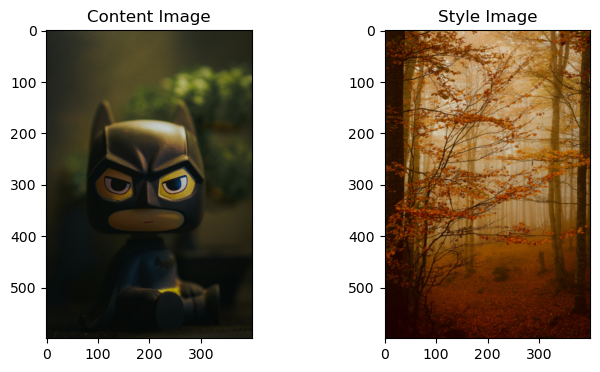

In [5]:
# Convert the images to numpy arrays
def tensor_to_image(tensor):
    # Invert normalization by reversing the mean and std
    denormalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
    )

    # Apply denormalization, convert to numpy, squeeze and transpose (C x H x W -> H x W x C)
    image = denormalize(tensor).cpu().numpy().squeeze().transpose(1, 2, 0)

    # Clip values to stay within the [0, 1] range
    return np.clip(image, 0, 1)


# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.title.set_text("Content Image")
ax1.imshow(tensor_to_image(content), label="Content")

ax2.title.set_text("Style Image")
ax2.imshow(tensor_to_image(style), label="Style")
plt.show()

## Feature Extraction and Gram Matrix

In [ ]:
def extract_features(image, model, layers):
    features = {}
    x = image

    # Iterate through the model layers using named_children()
    for name, layer in model.named_children():
        # Apply each layer to the image and store the result
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features


def gram_matrix(tensor):
    # Get the batch size, depth, height, and width of the tensor
    _, d, h, w = tensor.size()
    # Reshape the tensor to have the shape (depth, height * width)
    tensor = tensor.view(d, h * w)
    # Compute the Gram matrix
    gram = torch.mm(tensor, tensor.t())
    return gram

## Loss Functions and Optimization

In [ ]:
# Load the JSON file
with open("model_config.json", "r") as json_file:
    data = json.load(json_file)

# Extracting data into variables
layers = data["layers"]
style_weights = data["style_weights"]
content_weight = data["content_weight"]
style_weight = data["style_weight"]

## Training and Evaluation of Style Transfer Models

In [8]:
# Function to calculate the content loss
def calculate_content_loss(target_features, content_features, layer):
    return torch.mean((target_features[layer] - content_features[layer]) ** 2)


# Function to calculate the style loss
def calculate_style_loss(target_features, style_grams, style_weights):
    style_loss = 0
    for layer, weight in style_weights.items():
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = weight * torch.mean((target_gram - style_gram) ** 2)
        style_loss += layer_style_loss / (d * h * w)
    return style_loss

In [9]:
# Ensure that the correct model and layers are used for both content and style features
content_features = extract_features(content, model_dict["vgg-19"].features, layers["vgg-19"])
style_features = extract_features(style, model_dict["vgg-19"].features, layers["vgg-19"])

# Compute the gram matrices for the style features
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Ensure that the content tensor is moved to the correct device and requires gradient
target = content.clone().requires_grad_(True).to(device)

 10%|█         | 515/5000 [00:34<04:11, 17.85it/s]

Step 500/5000 - Total loss: 77946808.0000, Content loss: 1.8208, Style loss: 77.9468


 20%|██        | 1015/5000 [01:08<03:44, 17.76it/s]

Step 1000/5000 - Total loss: 37076484.0000, Content loss: 1.8925, Style loss: 37.0765


 30%|███       | 1515/5000 [01:43<03:17, 17.62it/s]

Step 1500/5000 - Total loss: 21100942.0000, Content loss: 1.9455, Style loss: 21.1009


 40%|████      | 2015/5000 [02:18<02:50, 17.47it/s]

Step 2000/5000 - Total loss: 13577088.0000, Content loss: 2.0073, Style loss: 13.5771


 50%|█████     | 2515/5000 [02:53<02:20, 17.69it/s]

Step 2500/5000 - Total loss: 9377942.0000, Content loss: 2.0527, Style loss: 9.3779


 60%|██████    | 3015/5000 [03:28<01:53, 17.49it/s]

Step 3000/5000 - Total loss: 6638883.5000, Content loss: 2.0912, Style loss: 6.6389


 70%|███████   | 3515/5000 [04:04<01:24, 17.65it/s]

Step 3500/5000 - Total loss: 4707720.5000, Content loss: 2.1145, Style loss: 4.7077


 80%|████████  | 4015/5000 [04:39<00:56, 17.48it/s]

Step 4000/5000 - Total loss: 3321514.7500, Content loss: 2.1396, Style loss: 3.3215


 90%|█████████ | 4515/5000 [05:14<00:27, 17.57it/s]

Step 4500/5000 - Total loss: 2342031.7500, Content loss: 2.1640, Style loss: 2.3420


100%|██████████| 5000/5000 [05:49<00:00, 14.31it/s]

Step 5000/5000 - Total loss: 1670687.5000, Content loss: 2.1806, Style loss: 1.6707


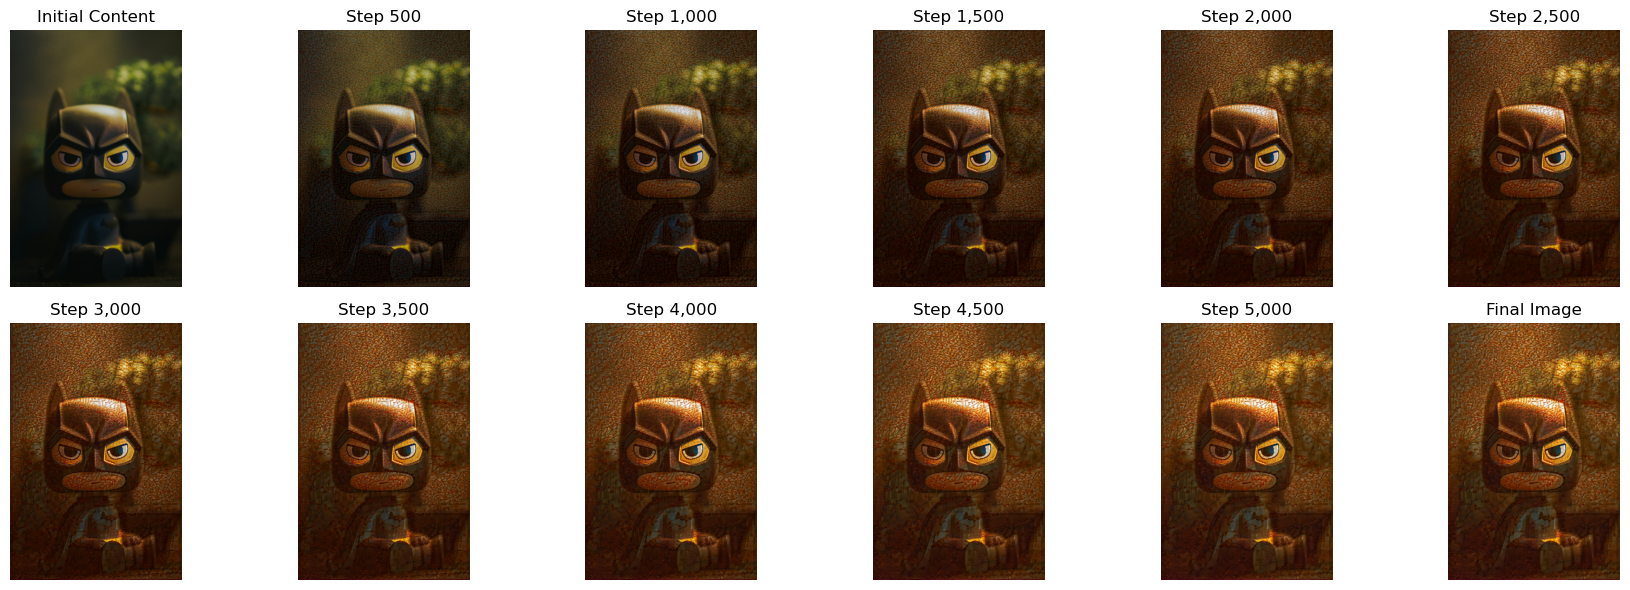

In [10]:
# Define hyperparameters
optimizer = optim.Adam([target], lr=0.001)
steps = 5000
checkpoints = 10

# Store the images at equal intervals
saved_images = []

# Optimization loop
for step in tqdm(range(1, steps + 1)):
    # Extract features from target image
    target_features = extract_features(
        target, model_dict["vgg-19"].features, layers["vgg-19"]
    )

    # Calculate content and style losses
    content_loss = calculate_content_loss(target_features, content_features, "conv5_1")
    style_loss = calculate_style_loss(
        target_features, style_grams, style_weights["vgg-19"]
    )

    # Calculate total loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # Backpropagate and update target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Save intermediate images at equal intervals
    if step % (steps // checkpoints) == 0:
        saved_images.append(tensor_to_image(target.detach()))
        print(
            f"Step {step}/{steps} - Total loss: {total_loss.item():.4f}, "
            f"Content loss: {content_loss.item():.4f}, Style loss: {style_loss.item():.4f}"
        )


# Include the original content image at the start and the final target image at the end
saved_images.insert(0, tensor_to_image(content))  # Add the content image at the start
saved_images.append(tensor_to_image(target.detach()))  # Add the final image at the end

# Create a plot with 2 rows and 6 columns
fig, axes = plt.subplots(2, 6, figsize=(18, 6))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot the images
for i, image in enumerate(saved_images):
    title = (
        f"Step {i * (steps // checkpoints):,}"
        if i > 0 and i < len(saved_images) - 1
        else "Initial Content"
        if i == 0
        else "Final Image"
    )
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(title)

# Show the plot
plt.tight_layout()
plt.show()
